In [1]:
from data.loader import load_dataset, load_train_dataset
from models.u2net import U2NET, bce_loss

import matplotlib.pyplot as plt

import tensorflow as tf
import keras
import os

In [2]:
TRAIN_PATH = "./datasets/DUTS/DUTS-TR/"
TEST_PATH = "./datasets/DUTS/DUTS-TE/"

IMAGE_SHAPE = (320, 320, 3)
MASK_SHAPE = (320, 320, 1)

# Training
BATCH_SIZE = 8
EPOCHS = 100
LEARNING_RATE = 0.001

In [3]:
def display(display_list, titles = ['Input Image', 'True Mask', 'Predicted Mask']):
    assert len(display_list) == len(titles), "Размер списка изображений должен соотвествовать размеру списка заголовков"
    
    plt.figure(figsize=(12, 12))
    
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(titles[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.show()

In [4]:
train_dataset = load_train_dataset(
    images_dir_path = os.path.join(TRAIN_PATH, "Image/*"),
    masks_dir_path = os.path.join(TRAIN_PATH, "Mask/*"),
    image_shape = IMAGE_SHAPE,
    mask_shape = MASK_SHAPE,
    batch=BATCH_SIZE,
    needAugmentation=True
)

test_dataset = load_dataset(
    images_dir_path = os.path.join(TEST_PATH, "Image/*"),
    masks_dir_path = os.path.join(TEST_PATH, "Mask/*"),
    image_shape = IMAGE_SHAPE,
    mask_shape = MASK_SHAPE
).batch(BATCH_SIZE)

2023-02-15 13:00:02.845819: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-15 13:00:02.845946: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-02-15 13:00:03.218331: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


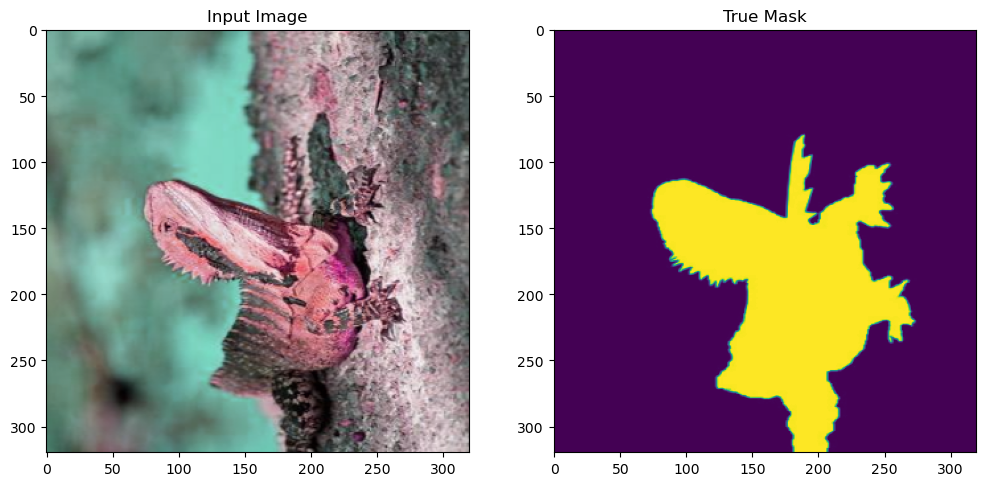

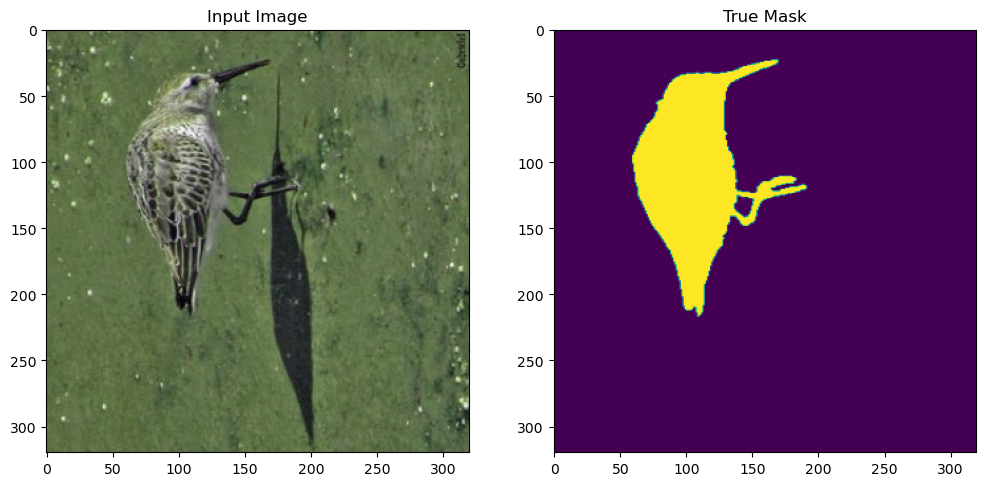

In [5]:
for images, masks in train_dataset.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask], ['Input Image', 'True Mask'])

In [6]:
adam = keras.optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=.9, beta_2=.999, epsilon=1e-08)
model = U2NET(shape_image=IMAGE_SHAPE)
model.compile(optimizer=adam, loss=bce_loss)

In [7]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
keras.backend.set_session(sess)
print("Session:", tf.config.list_physical_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7684265812312495577
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9392095232
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9374286922358182005
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]
Num GPUs Available:  1
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5

Session: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [9]:
callbacks = [
    keras.callbacks.TensorBoard(log_dir="./logs"),
    keras.callbacks.BackupAndRestore("./bkp"),
]

model.fit(train_dataset, validation_data=test_dataset, callbacks=callbacks, epochs=EPOCHS)
model.save('u2net.h5', include_optimizer=False)

Epoch 1/100
1320/1320 [==============================] - ETA: 0s - loss: 2.1432

INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


1320/1320 [==============================] - 813s 592ms/step - loss: 2.1432 - val_loss: 3.0982
Epoch 2/100
1320/1320 [==============================] - ETA: 0s - loss: 1.5421

INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


1320/1320 [==============================] - 762s 575ms/step - loss: 1.5421 - val_loss: 2.2331
Epoch 3/100
1320/1320 [==============================] - ETA: 0s - loss: 1.3351

INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


1320/1320 [==============================] - 768s 579ms/step - loss: 1.3351 - val_loss: 1.8273
Epoch 4/100
1320/1320 [==============================] - 696s 524ms/step - loss: 1.2089 - val_loss: 1.9478
Epoch 5/100
1320/1320 [==============================] - ETA: 0s - loss: 1.1177

INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


1320/1320 [==============================] - 775s 585ms/step - loss: 1.1177 - val_loss: 1.7939
Epoch 6/100
1320/1320 [==============================] - 693s 523ms/step - loss: 1.0145 - val_loss: 1.8208
Epoch 7/100
1320/1320 [==============================] - 695s 524ms/step - loss: 0.9282 - val_loss: 1.9865
Epoch 8/100
1320/1320 [==============================] - ETA: 0s - loss: 0.8679

INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


1320/1320 [==============================] - 772s 582ms/step - loss: 0.8679 - val_loss: 1.7097
Epoch 9/100
1320/1320 [==============================] - ETA: 0s - loss: 0.7958

INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


1320/1320 [==============================] - 778s 587ms/step - loss: 0.7958 - val_loss: 1.6712
Epoch 10/100
1320/1320 [==============================] - ETA: 0s - loss: 0.7345

INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


1320/1320 [==============================] - 782s 589ms/step - loss: 0.7345 - val_loss: 1.5480
Epoch 11/100
1320/1320 [==============================] - 708s 533ms/step - loss: 0.6767 - val_loss: 1.6241
Epoch 12/100
1320/1320 [==============================] - 710s 535ms/step - loss: 0.6302 - val_loss: 1.8143
Epoch 13/100
1320/1320 [==============================] - 708s 533ms/step - loss: 0.5760 - val_loss: 1.5892
Epoch 14/100
1320/1320 [==============================] - 708s 533ms/step - loss: 0.5427 - val_loss: 1.8804
Epoch 15/100
1320/1320 [==============================] - 709s 534ms/step - loss: 0.5007 - val_loss: 2.1790
Epoch 16/100
1320/1320 [==============================] - 708s 534ms/step - loss: 0.4698 - val_loss: 1.9756
Epoch 17/100
1320/1320 [==============================] - 710s 535ms/step - loss: 0.4561 - val_loss: 1.7009
Epoch 18/100
1320/1320 [==============================] - 709s 534ms/step - loss: 0.4009 - val_loss: 2.0647
Epoch 19/100
1320/1320 [=================

Epoch 86/100
1320/1320 [==============================] - 708s 533ms/step - loss: 0.1284 - val_loss: 2.3144
Epoch 87/100
1320/1320 [==============================] - 710s 535ms/step - loss: 0.1570 - val_loss: 2.3263
Epoch 88/100
1320/1320 [==============================] - 709s 534ms/step - loss: 0.1378 - val_loss: 2.3965
Epoch 89/100
1320/1320 [==============================] - 710s 534ms/step - loss: 0.1247 - val_loss: 2.5245
Epoch 90/100
1320/1320 [==============================] - 708s 534ms/step - loss: 0.1206 - val_loss: 2.7372
Epoch 91/100
1320/1320 [==============================] - 701s 528ms/step - loss: 0.1208 - val_loss: 2.4843
Epoch 92/100
1320/1320 [==============================] - 703s 529ms/step - loss: 0.1220 - val_loss: 2.4336
Epoch 93/100
1320/1320 [==============================] - 703s 529ms/step - loss: 0.1220 - val_loss: 2.4137
Epoch 94/100
1320/1320 [==============================] - 703s 529ms/step - loss: 0.1247 - val_loss: 3.4992
Epoch 95/100
1320/1320 [====

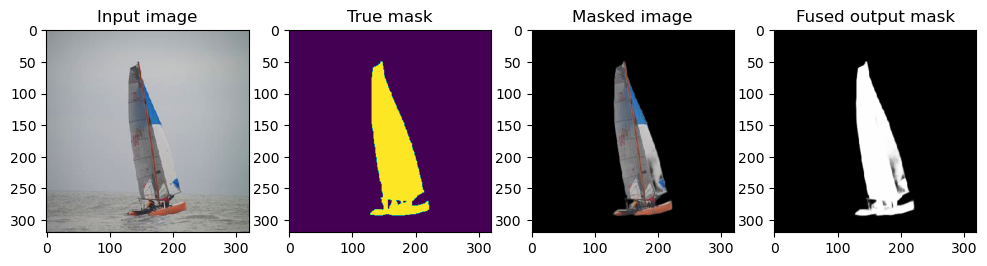

In [45]:
import numpy as np
for image, mask in test_dataset.take(1):
    out = model(image)
    display(
        [image[0], mask[0], np.multiply(image[0], np.tile(out[0][0], [1, 1, 3])), np.tile(out[0][0], [1, 1, 3])],
        ["Input image", "True mask", "Masked image", "Fused output mask"]
    )

In [2]:
%load_ext tensorboard
%tensorboard --logdir './logs'

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
